# Assignment 5
In this assignment, we will implement a simplified version of object detection process. 

In [1]:
from __future__ import print_function
import random 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io
from skimage.feature import hog
from skimage import data, color, exposure
from skimage.transform import rescale, resize, downscale_local_mean
import glob, os
import fnmatch
import time
import math

import warnings
warnings.filterwarnings('ignore')

from detection import *
from util import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Part 1: Hog Representation (1 point)

In this section, we will compute the average hog representation of human faces.<br>
There are 31 aligned face images provided in the `\face` folder. They are all aligned and have the same size. We will get an average face from these images and compute a hog feature representation for the averaged face, which is treated as the face model. Note that, in practice, we get the face model by training a SVM classifier on a separate dataset of face vs non-face images. This step has been described in the lectrue 18. However, due to the scope of assignment, this step had been greatly simplified to only compute the hog representation of average face<br>
Use the hog function provided by skimage library, and implement a hog representation of objects.
Implement **`hog_feature`** function in `detection.py`

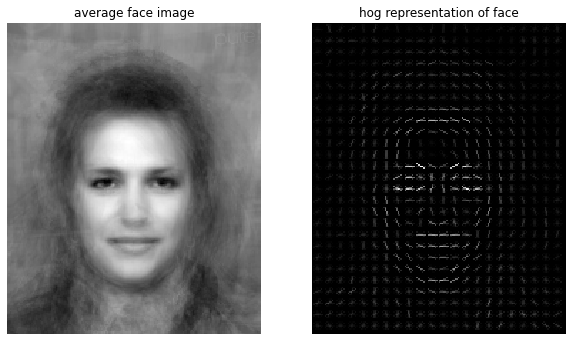

In [3]:
image_paths = fnmatch.filter(os.listdir('./face'), '*.jpg')
list.sort(image_paths)
n = len(image_paths)
face_shape = io.imread('./face/'+image_paths[0], as_gray=True).shape
avg_face= np.zeros((face_shape))
for i,image_path in enumerate(image_paths):
    image = io.imread('./face/'+image_path, as_gray=True)
    avg_face = np.asarray(image)+np.asarray(avg_face)
avg_face = avg_face/n

(face_feature, face_hog) = hog_feature(avg_face)

plt.subplot(1,2,1)
plt.imshow(avg_face)
plt.axis('off')
plt.title('average face image')

plt.subplot(1,2,2)
plt.imshow(face_hog)
plt.title('hog representation of face')
plt.axis('off')

plt.show()


# Part 2: Sliding Window (2 points)
Implement **`sliding_window`** function to have windows slide across an image with a specific window size. The window slides through the image and check if an object is detected with a high score at every location. These scores will generate a response map and you will be able to find the location of the window with the highest hog score. 


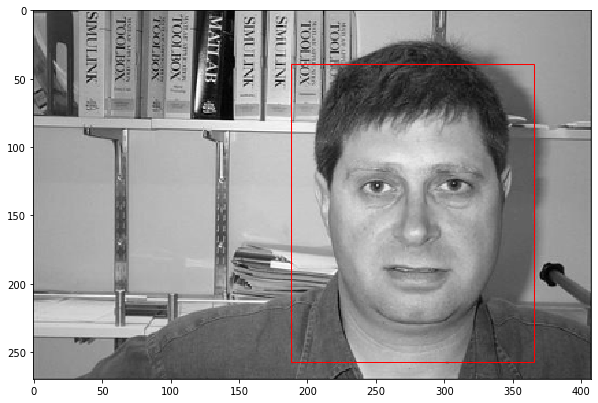

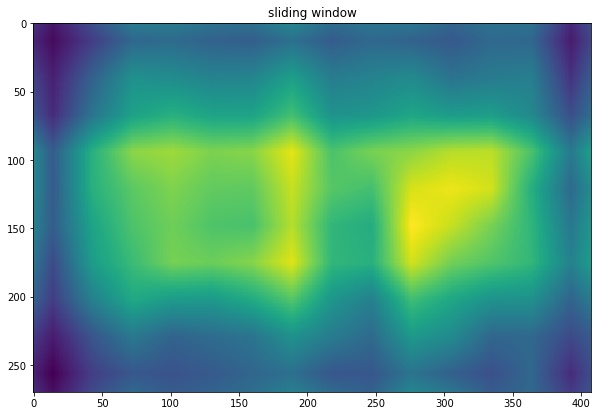

In [5]:
image_path = 'image_0001.jpg'

image = io.imread(image_path, as_gray=True)
image = rescale(image, 0.8)

(hogFeature, hogImage) = hog_feature(image)

(winH, winW) = face_shape
(score, r, c, response_map) = sliding_window(image, face_feature, stepSize=30, windowSize=face_shape)
crop = image[r:r+winH, c:c+winW]

fig,ax = plt.subplots(1)
ax.imshow(image)
rect = patches.Rectangle((c,r),winW,winH,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

plt.imshow(response_map,cmap='viridis', interpolation='nearest')
plt.title('sliding window')
plt.show()

Sliding window successfully found the human face in the above example. However, in the cell below, we are only changing the scale of the image, and you can see that sliding window does not work once the scale of the image is changed. 

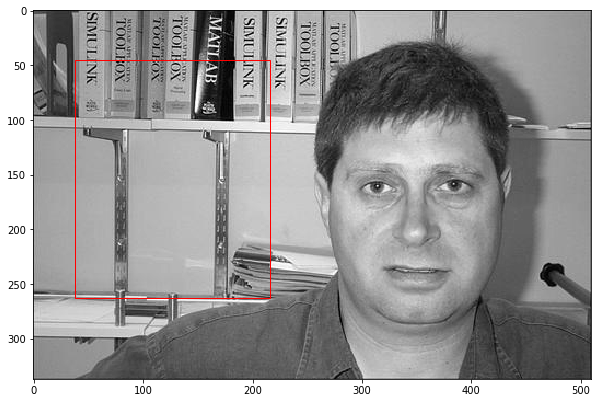

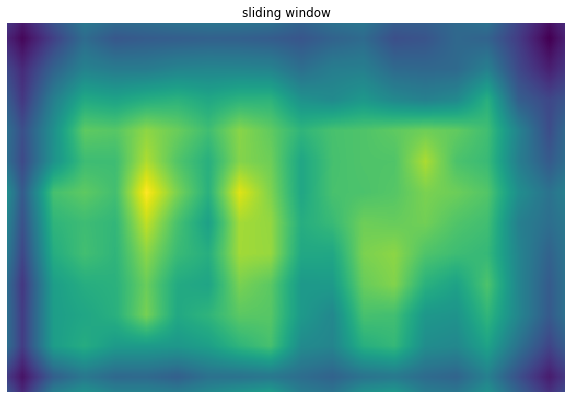

In [7]:
image_path = 'image_0001.jpg'
image = io.imread(image_path, as_gray=True)
image = rescale(image, 1.0)


(winH, winW) = face_shape
(score, r, c, max_response_map) = sliding_window(image, face_feature, stepSize=30, windowSize=face_shape)

crop = image[r:r+winH, c:c+winW]

fig,ax = plt.subplots(1)
ax.imshow(image)
rect = patches.Rectangle((c,r),winW,winH,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

plt.imshow(max_response_map,cmap='viridis', interpolation='nearest')
plt.title('sliding window')
plt.axis('off')
plt.show()


# Part 3: Image Pyramids (2 points)
In order to make sliding window work for different scales of images, you need to implement image pyramids where you resize the image to different scales and run the sliding window method on each resized image. This way you scale the objects and can detect both small and large objects. 


###  3.1 Image Pyramid (0.5 point)

Implement **`pyramid`** function in `detection.py`, this will create pyramid of images at different scales. Run the following code, and you will see the shape of the original image gets smaller until it reaches a minimum size.


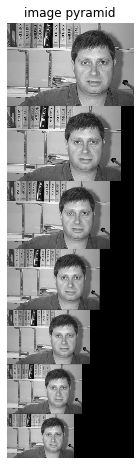

In [9]:
image_path = 'image_0001.jpg'

image = io.imread(image_path, as_gray=True)
image = rescale(image, 1.2)

images = pyramid(image, scale = 0.9)
sum_r = 0
sum_c = 0
for i,result in enumerate(images):
    (scale, image) = result
    if (i==0):
        sum_c = image.shape[1]
    sum_r+=image.shape[0]

composite_image = np.zeros((sum_r, sum_c))

pointer = 0
for i, result in enumerate(images):
    (scale, image) = result   
    composite_image[pointer:pointer+image.shape[0], :image.shape[1]] = image
    pointer+= image.shape[0]
    
plt.imshow(composite_image)
plt.axis('off')
plt.title('image pyramid')
plt.show()


###  3.2 Pyramid Score (1 points)

After getting the image pyramid, we will run sliding window on all the images to find a place that gets the highest score. Implement **`pyramid_score`** function in `detection.py`. It will return the highest score and its related information in the image pyramids.

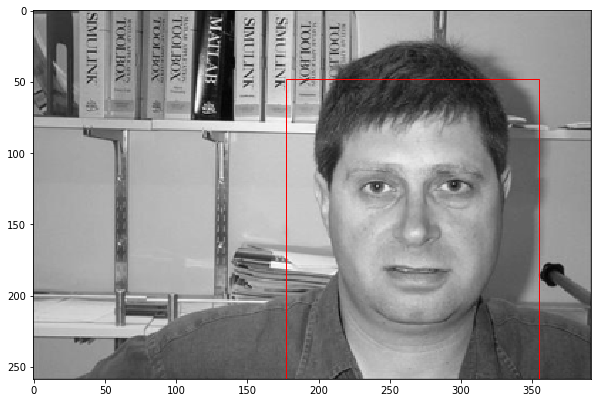

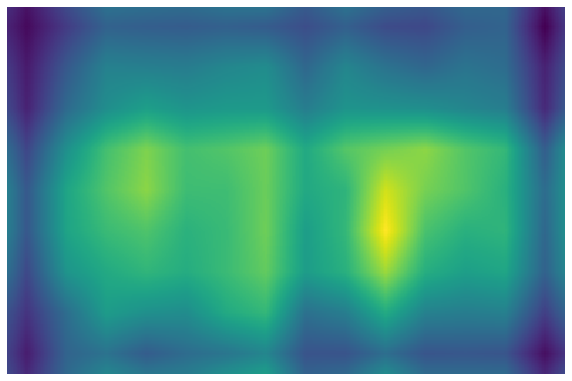

In [11]:
image_path = 'image_0001.jpg'

image = io.imread(image_path, as_gray=True)
image = rescale(image, 1.2)

(winH, winW) = face_shape
max_score, maxr, maxc, max_scale, max_response_map = pyramid_score \
        (image, face_feature, face_shape, stepSize = 30, scale=0.8)

fig,ax = plt.subplots(1)
ax.imshow(rescale(image, max_scale))
rect = patches.Rectangle((maxc,maxr),winW,winH,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

plt.imshow(max_response_map, cmap='viridis', interpolation='nearest')
plt.axis('off')
plt.show()

From the above example, we can see that image pyramid has fixed the problem of scaling. Then in the example below, we will try another image.

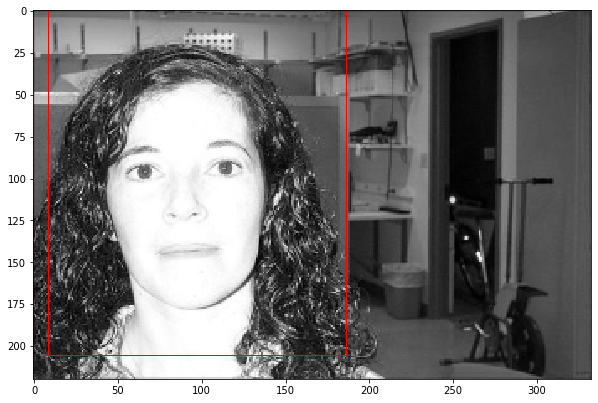

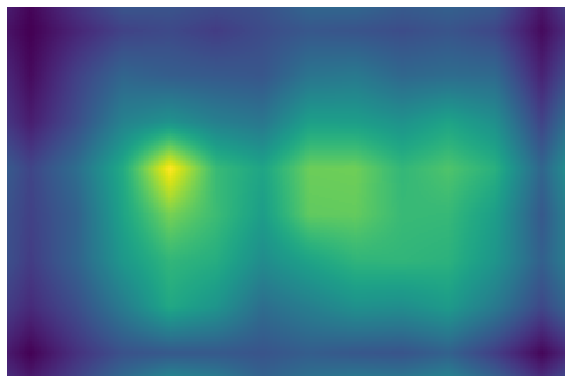

In [13]:
image_path = 'image_0338.jpg'
image = io.imread(image_path, as_gray=True)
image = rescale(image, 1.0)

(winH, winW) = face_shape

max_score, maxr, maxc, max_scale, max_response_map = pyramid_score \
    (image, face_feature, face_shape, stepSize = 30, scale=0.8)

fig,ax = plt.subplots(1)
ax.imshow(rescale(image, max_scale))
rect = patches.Rectangle((maxc,maxr),winW,winH,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

plt.imshow(max_response_map,cmap='viridis', interpolation='nearest')
plt.axis('off')
plt.show()
    

Again, we can also detect the face successfully. Then, how about this image?

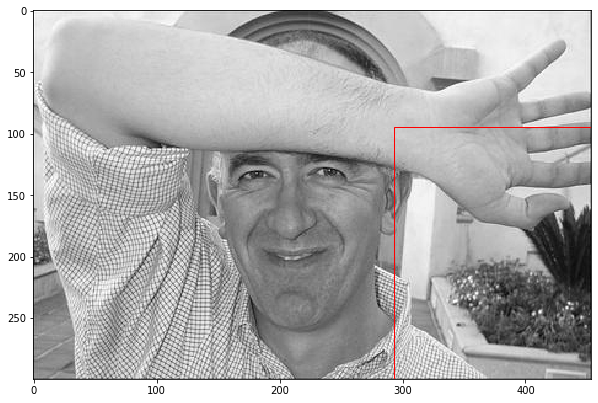

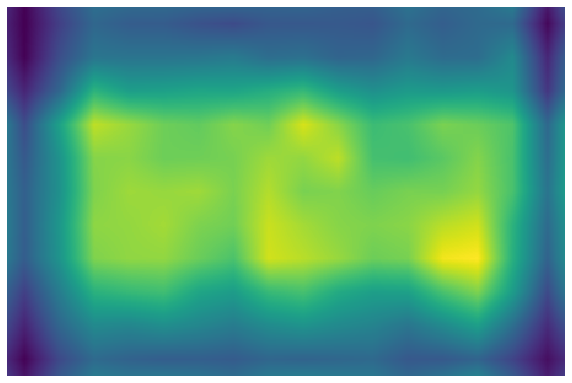

In [15]:
image_path = 'image_0319.jpg'
image = io.imread(image_path, as_gray=True)
image = rescale(image, 1.0)

(winH, winW) = face_shape

max_score, maxr, maxc, max_scale, max_response_map = pyramid_score \
    (image, face_feature, face_shape, stepSize = 30, scale=0.8)

fig,ax = plt.subplots(1)
ax.imshow(rescale(image, max_scale))
rect = patches.Rectangle((maxc,maxr),winW,winH,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

plt.imshow(max_response_map,cmap='viridis', interpolation='nearest')
plt.axis('off')
plt.show()

### 3.3 Question (0.5 point)

Seems that the face in the above example is not detected correctly anymore. What is the problem here? Suggest at least one approach to solve this problem.

**Your Answer:** Write your answer in this markdown cell.

**Credit**: Juan Carlos Niebles and Ranjay Krishna